In [170]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from scipy.stats import norm
from astropy import modeling
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
#import ugradio
sbn.set_style('whitegrid')
sbn.axes_style()
plt.rc('font', family = 'serif')
import barycorrpy
import astropy.time
import time
import datetime
from matplotlib.patches import Rectangle

# Functions

In [3]:
def scale(data, volt_range):
    """
    Rescales sampler data.
    
    Parameters:
    data (array) : data to be rescaled
    volt_range (double) : volt range input parameter 
    
    Returns:
    output (array) : rescaled data
    """
    
    output = (data * volt_range) / np.power(2, 15) / 2 # factor of 2
    return output

def load(filename, volt_range, nblocks, nsamples = 16000):
    """
    Loads a file with collected data. 
    
    Parameters:
    filename (string) : name of the file
    volt_range (double) : volt range input parameter
    nblocks (int) : number of data blocks
    
    Returns:
    complex (array) : rescaled data, split by block
    real (array) : real component
    imag (array) : imaginary component
    """
    
    data = np.load(filename)
    scaled = scale(data, volt_range)
    split = np.split(scaled, 2)
    real = split[0]
    imag = split[1]
    real_split = np.split(real, nblocks)
    imag_split = np.split(imag, nblocks)
    output = []
    for i in range(0, nblocks):
        output.append(real_split[i] + 1j * imag_split[i])
    return output, real, imag

def get_pwr(signal, v_samp, nsamples):
    """
    Returns the power spectrum of a given signal as a function of frequency.
    
    Parameters:
    signal (array) : signal data
    v_samp (double) : sampling frequency
    nsamples (int) : number of samples per block
    
    Returns: 
    power (array) : power spectrum
    freqs (array) : frequencies
    """
    
    nblocks = len(signal)
    power = []
    for i in range(0, nblocks):
        ft = np.fft.fft(signal[i])
        power.append(np.abs(ft) ** 2)
    dt = 1 / v_samp
    freqs = np.fft.fftfreq(nsamples, d = dt)
    
    return freqs, power

def avg_smooth(data, freqs, nsmooth):
    """
    Smooths data by taking averages over bins of a specified size.
    
    Parameters:
    data (array) : data to be smoothed
    freqs (array) : frequencies
    nsmooth (int) : number of bins
    """
    
    data_split = np.split(data, nsmooth)
    freqs_split = np.split(freqs, nsmooth)
    data_smooth = []
    freqs_smooth = []
    for i in range(0, nsmooth):
        data_smooth.append(np.mean(data_split[i], axis = 0))
        freqs_smooth.append(np.mean(freqs_split[i], axis = 0))
    return data_smooth, freqs_smooth

def med_smooth(data, freqs, nsmooth):
    """
    Smooths data by taking means over bins of a specified size.
    
    Parameters:
    data (array) : data to be smoothed
    freqs (array) : frequencies
    nsmooth (int) : number of bins
    """
    
    data_split = np.split(data, nsmooth)
    freqs_split = np.split(freqs, nsmooth)
    data_smooth = []
    freqs_smooth = []
    for i in range(0, nsmooth):
        data_smooth.append(np.median(data_split[i], axis = 0))
        freqs_smooth.append(np.median(freqs_split[i], axis = 0))
    return data_smooth, freqs_smooth

def _pack_prms(amp, avg, sig):
    '''Internal. Convert user arguments to parameter list.'''
    prms = np.array([amp, avg, sig])
    prms.shape = (3,-1)
    return prms.T.flatten()

def _unpack_prms(prms):
    '''Internal. Convert parameter list to user arguments.'''
    amp = np.array(prms[0::3]); amp.shape = (-1,1)
    avg = np.array(prms[1::3]); avg.shape = (-1,1)
    sig = np.array(prms[2::3]); sig.shape = (-1,1)
    return amp, avg, sig

def _gauss(x, *prms):
    '''Internal. Gaussian model that is fit to the data.'''
    amp, avg, sig = _unpack_prms(prms)
    ans = amp * np.exp(-(x-avg)**2/(2.*sig**2))
    return np.sum(amp * np.exp(-(x-avg)**2/(2.*sig**2)), axis=0)

def gaussfit(x, y, amp=1., avg=0., sig=1., return_cov=False):
    '''Fit amp, avg, and sig for a Gaussian [y = amp * e^(-(x-avg)^2/(2*sig^2)].
    amp/avg/sig can be lists/arrays to simultaneously fit multiple Gaussians.
    Parameters
    ----------
    x : x coordinate at which Gaussian is evaluated
    y : measured y coordinate to which Gaussian is compared
    amp : first guess at amp, the amplitude(s) of the Gaussian(s), default=1.
    avg : first guess at avg, the average(s) of the Gaussian(s), default=0.
    sig : first guess at sig, the width(s) of the Gaussian(s), default=1.
    return_cov : return the [amp, avg, sig] covariance matrix of the solution
    Returns
    -------
    ans : dictionary with amp/avg/sig keys and fit solutions as values.
    prm_covariance : the [amp, avg, sig] covariance matrix'''
    prms0 = _pack_prms(amp, avg, sig)
    prms, prm_covariance = curve_fit(_gauss, x, y, p0=prms0)
    amp, avg, sig = _unpack_prms(prms)
    ans = {'amp':amp.flatten(), 'avg':avg.flatten(), 'sig':sig.flatten()}
    if return_cov:
        return ans, prm_covariance
    else:
        return ans

def gaussval(x, amp, avg, sig):
    '''Evaluate a Gaussian given amp, avg, and sig [y = amp * e^(-(x-avg)^2/(2*sig^2)].
    amp/avg/sig can be lists/arrays to simultaneously fit multiple Gaussians.
    Parameters
    ----------
    x : x coordinate at which Gaussian is evaluated
    amp : amplitude(s) of Gaussian(s)
    avg : center point(s) of Gaussian(s)
    sig : width(s) of Gaussian(s)
    Returns
    -------
    y : the evaluated Gaussian [y = amp * e^(-(x-avg)^2/(2*sig^2)]'''
    prms = _pack_prms(amp, avg, sig)
    return _gauss(x, *prms)

def unix_time(jd=None):
    '''Return (current) time, in seconds since the Epoch (00:00:00 
    Coordinated Universal Time (UTC), Thursday, 1 January 1970).
    Parameters
    ----------
    jd : float, julian date, default=now
    Returns
    -------
    t : float, seconds since the Epoch'''
    if jd is None:
        return time.time()
    else:
        t = astropy.time.Time(jd, format='jd')
        return t.unix

def local_time(unix_t=None):
    '''Return (current) local time as a string.
    Parameters
    ----------
    unix_t : seconds since the Epoch, default=now
    Returns
    -------
    t : string, e.g. "Mon Jan 23 14:56:59 2018"'''
    return time.ctime(unix_t)

def utc(unix_t=None, fmt='%a %b %d %X %Y'):
    '''Return (current) UTC time as a string.
    Parameters
    ----------
    unix_t : seconds since the Epoch, default=now
    fmt    : format string (see time.strftime), default produces 
             "Mon Jan 23 14:56:59 2018"
    Returns
    -------
    t : string, e.g. "Mon Jan 23 14:56:59 2018"'''
    gmt = time.gmtime(unix_t)
    return time.strftime(fmt, gmt)

def julian_date(unix_t=None):
    '''Return (current) time as a Julian date.
    Parameters
    ----------
    unix_t : seconds since the Epoch, default=now
    Returns
    -------
    jd : float, julian date'''
    if unix_t is None:
        unix_t = time.time()
    t = astropy.time.Time(unix_t, format='unix')
    return t.jd

def lst(jd=None, lon=-122.2573):
    '''Return (current) LST.
    Parameters
    ----------
    jd : float, julian date, default=now
    lon : float, degrees longitude, default=-122.2573
    Returns
    -------
    t : float, local sidereal time in radians'''
    if jd is None:
        jd = julian_date()
    t = astropy.time.Time(jd, format='jd')
    return t.sidereal_time('apparent', longitude=lon).radian

def get_projected_velocity(ra, dec, jd, obs_lat=37.873199, obs_lon=-122.2573, 
        obs_alt=120, epoch=2451545.):
    '''Compute the projected velocity of the telescope wrt the 
    Local Standard of Rest.
    Parameters
    ----------
    ra, dec : float degrees, the RA/DEC of target
    jd      : float, julian date (UTC) of the observation
    obs_lat : float degrees, latitude of observatory, default=lat
    obs_lon : float degrees, longitude of observatory, default=lon
    obs_alt : float meters, altitude of observatory, default=alt
    epoch   : float, julian date epoch of ra/dec coordinates
              default=2451545 is J2000
    Returns
    -------
    v : float m/s, barycenter-corrected radial velocity,
        see (Wright & Eastman, 2014) '''
    jd_utc = astropy.time.Time(jd, format='jd', scale='utc')
    proper_motion_ra = 0. # proper motion in ra, mas/yr
    proper_motion_dec = 0. # proper motion in dec, mas/yr
    parallax = 0. # parallax of target in mas
    rv = 0. # radial velocity of target in m/s
    zmeas = 0. # measured redshift of spectrum
    ephemeris = 'de430' # ephemeris from jplephem, ~100MB download first use
    v, warn, flag = barycorrpy.get_BC_vel(JDUTC=jd_utc, ra=ra, dec=dec, 
        lat=obs_lat, longi=obs_lon, alt=obs_alt,
        pmra=proper_motion_ra, pmdec=proper_motion_dec,
        px=parallax, rv=rv, zmeas=zmeas,
        epoch=epoch, ephemeris=ephemeris, leap_update=False)
    return v

# Not Pointed

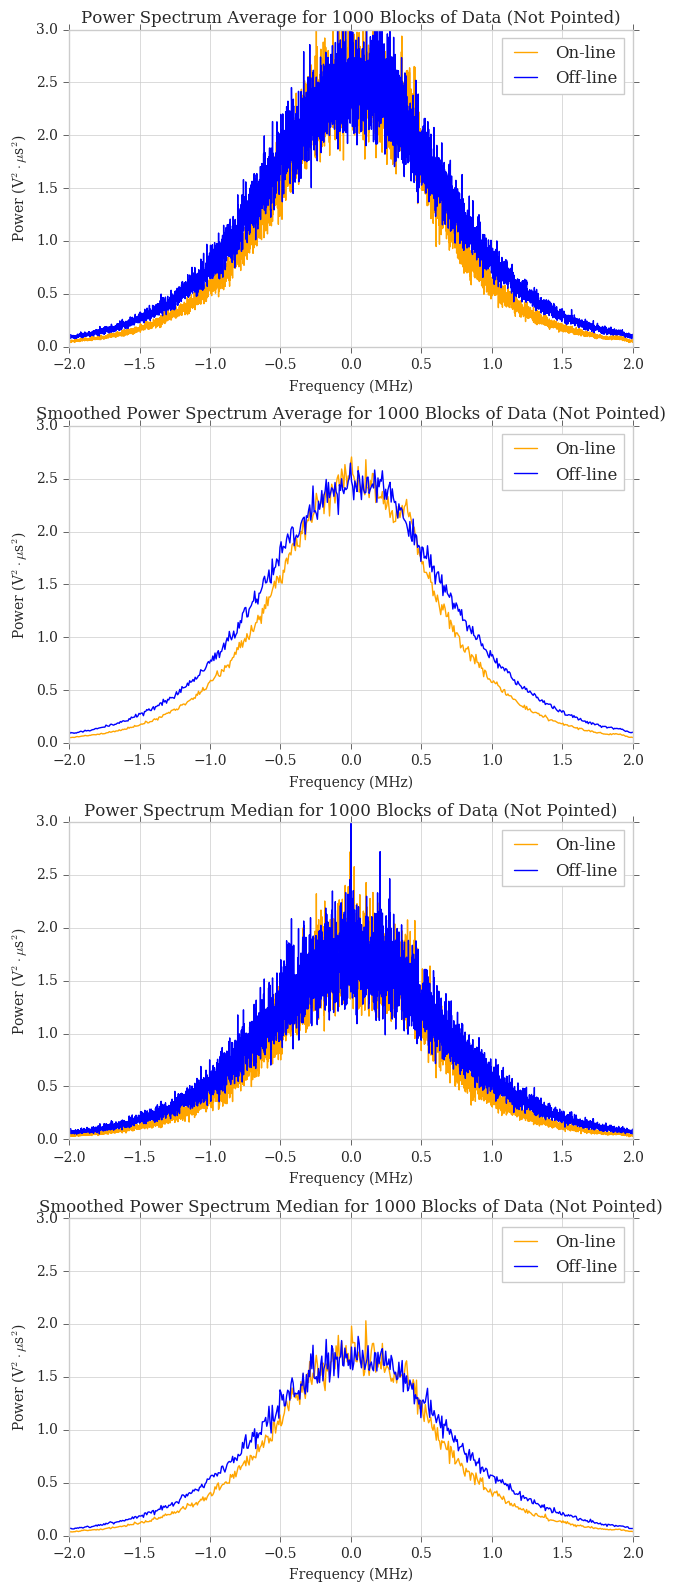

In [7]:
#UPPER/LOWER POWER SPECTRA

file1 = 'cold_data_100mV.npy'
file2 = 'test_100mV.npy'

div = 5
v_samp = 62.5 / div
v_range = 0.1
nsamples = 16000
nblocks = 99

data1, real, imag = load(file1, v_range, nblocks)
data2, real, imag = load(file2, v_range, nblocks)
baseline = (np.asarray(data1) + np.asarray(data2)) / len(data1)
dataz_on = (baseline + np.asarray(data1)) / 3 
dataz_off = (baseline + np.asarray(data2)) / 2

freqs_coldon, poweron = get_pwr(dataz_on, v_samp, nsamples)
avg_coldon = np.mean(poweron, axis = 0)
med_coldon = np.median(poweron, axis = 0)

freqs_coldoff, poweroff = get_pwr(dataz_off, v_samp, nsamples)
avg_coldoff = np.mean(poweroff, axis = 0)
med_coldoff = np.median(poweroff, axis = 0)

smooth_div = 10
nsmooth = nsamples // smooth_div
smooth_avgcoldon, smooth_freqscoldon = avg_smooth(avg_coldon, freqs_coldon, nsmooth)
smooth_medcoldon, med_freqscoldon = med_smooth(med_coldon, freqs_coldon, nsmooth)
smooth_avgcoldoff, smooth_freqscoldoff = avg_smooth(avg_coldoff, freqs_coldoff, nsmooth)
smooth_medcoldoff, med_freqscoldoff = med_smooth(med_coldoff, freqs_coldoff, nsmooth)

fig = plt.figure(figsize = (7, 16))

ax1 = plt.subplot(4, 1, 1)
ax1.plot(-np.fft.fftshift(freqs_coldon), np.fft.fftshift(avg_coldon), label = 'On-line', color='orange')
ax1.plot(-np.fft.fftshift(freqs_coldoff), np.fft.fftshift(avg_coldoff), label = 'Off-line', color='b')
ax1.legend(loc = 'upper right')
ax1.set_xlim(-2, 2)
ax1.set_ylim(0, 3)
ax1.set_xlabel('Frequency (MHz)')
ax1.set_ylabel('Power (V$^2\cdot\mu$s$^2$)')
ax1.set_title('Power Spectrum Average for 1000 Blocks of Data (Not Pointed)')

ax2 = plt.subplot(4, 1, 2)
ax2.plot(-np.fft.fftshift(smooth_freqscoldon), np.fft.fftshift(smooth_avgcoldon), label = 'On-line', color='orange')
ax2.plot(-np.fft.fftshift(smooth_freqscoldoff), np.fft.fftshift(smooth_avgcoldoff), label = 'Off-line', color='b')
ax2.legend(loc = 'upper right')
ax2.set_xlim(-2, 2)
ax2.set_ylim(0, 3)
ax2.set_xlabel('Frequency (MHz)')
ax2.set_ylabel('Power (V$^2\cdot\mu$s$^2$)')
ax2.set_title('Smoothed Power Spectrum Average for 1000 Blocks of Data (Not Pointed)')

ax3 = plt.subplot(4, 1, 3)
ax3.plot(-np.fft.fftshift(freqs_coldon), np.fft.fftshift(med_coldon), label = 'On-line', color='orange')
ax3.plot(-np.fft.fftshift(freqs_coldoff), np.fft.fftshift(med_coldoff), label = 'Off-line', color='b')
ax3.legend(loc = 'upper right')
ax3.set_xlim(-2, 2)
ax3.set_ylim(0, 3)
ax3.set_xlabel('Frequency (MHz)')
ax3.set_ylabel('Power (V$^2\cdot\mu$s$^2$)')
ax3.set_title('Power Spectrum Median for 1000 Blocks of Data (Not Pointed)')

ax4 = plt.subplot(4, 1, 4)
ax4.plot(-np.fft.fftshift(med_freqscoldon), np.fft.fftshift(smooth_medcoldon), label = 'On-line', color='orange')
ax4.plot(-np.fft.fftshift(med_freqscoldoff), np.fft.fftshift(smooth_medcoldoff), label = 'Off-line', color='b')
ax4.legend(loc = 'upper right')
ax4.set_xlim(-2, 2)
ax4.set_ylim(0, 3)
ax4.set_xlabel('Frequency (MHz)')
ax4.set_ylabel('Power (V$^2\cdot\mu$s$^2$)')
ax4.set_title('Smoothed Power Spectrum Median for 1000 Blocks of Data (Not Pointed)')

fig.tight_layout()

0.05468750000000005


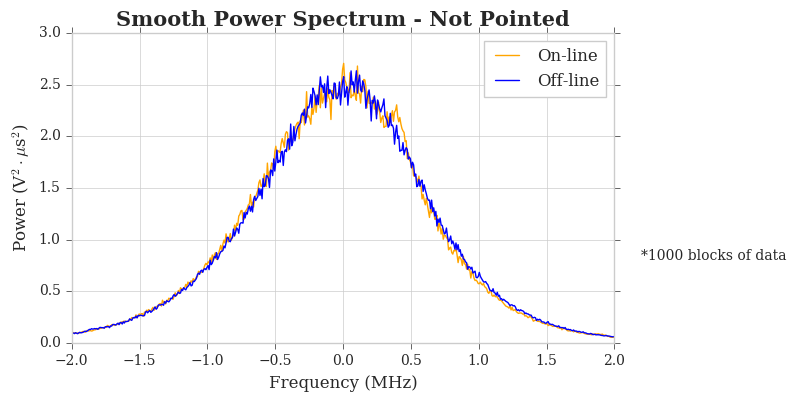

In [8]:
#NOT POINTED

r_on , l_on = np.split(np.asarray(smooth_avgcoldon),2)
r_off , l_off = np.split(np.asarray(smooth_avgcoldoff),2)

npoffline_signal = np.concatenate((r_on,l_off))[::-1]
nponline_signal = np.concatenate((r_off,l_on))

aligned_x = np.asarray(smooth_freqscoldoff)[::-1] - 0.05
print((aligned_x[0] - aligned_x[1]) * 7)
edited_off = np.concatenate((np.asarray(npoffline_signal)[7:], 
                             np.asarray(npoffline_signal)[:7]))

fig = plt.figure(figsize = (7, 4))
plt.plot(-np.fft.fftshift(smooth_freqscoldon), np.fft.fftshift(nponline_signal), label = 'On-line', color='orange')
plt.plot(-np.fft.fftshift(smooth_freqscoldoff), np.fft.fftshift(edited_off), label = 'Off-line', color='b')
plt.xlim(-2,2)
plt.title('Smooth Power Spectrum - Not Pointed', fontweight='bold', fontsize=15)
plt.xlabel('Frequency (MHz)', fontsize=12)
plt.ylabel('Power (V$^2\cdot\mu$s$^2$)', fontsize=12)
plt.text(2.2, 0.8, '*1000 blocks of data')
plt.legend()

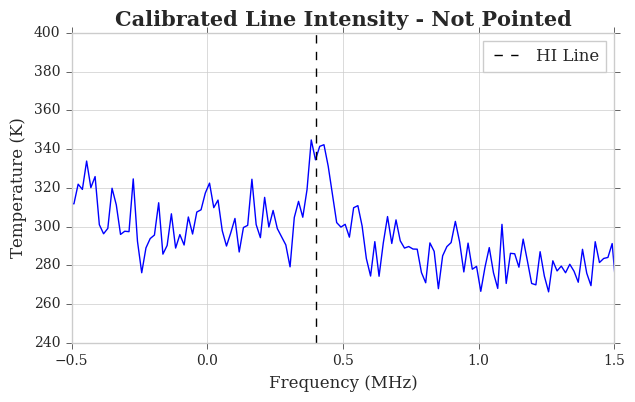

Gain = 304.2228435837575


In [9]:
#NOT POINTED

cal_file = 'cal_data_100mV.npy'
cold_file = 'cold_data_100mV.npy'

v_samp = 12.5
v_range = 0.1
nsamples = 16000
nblocks = 99

cold, real, imag = load(cold_file, v_range, nblocks)
cal, real, imag = load(cal_file, v_range, nblocks)
cold_freqs, cold_pwr = get_pwr(cold, v_samp, nsamples)
cal_freqs, cal_pwr = get_pwr(cal, v_samp, nsamples)
avg_cold = np.mean(cold_pwr, axis = 0)
avg_cal = np.mean(cal_pwr, axis = 0)

np_line = np.asarray(nponline_signal) / np.asarray(edited_off) 

gain = 300 * np.sum(avg_cold) / np.sum(avg_cal - avg_cold)
np_final = gain * np_line

smooth_div = 20
nsmooth = nsamples // smooth_div
npsmooth_avg, npavg_freqs = avg_smooth(np_final, cold_freqs, nsmooth)

fig = plt.figure(figsize = (7, 4))
plt.plot(-np.fft.fftshift(npavg_freqs), np.fft.fftshift(npsmooth_avg),color='b')
plt.xlim(-0.5, 1.5)
plt.ylim(240, 400)
plt.xlabel('Frequency (MHz)', fontsize=12)
plt.ylabel('Temperature (K)', fontsize=12)
plt.axvline(0.4, linestyle='--', color='black', label='HI Line')
plt.title('Calibrated Line Intensity - Not Pointed', fontweight='bold', fontsize=15)
plt.legend()
plt.show()
fig.tight_layout()
print('Gain =', gain)

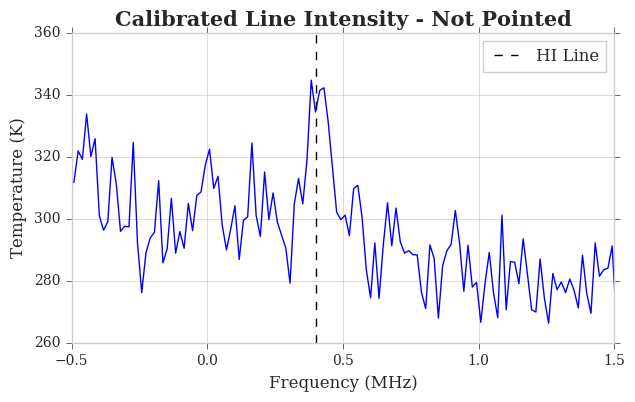

In [10]:
filter = np.ones(len(npsmooth_avg), dtype = bool)
for i in range(len(npavg_freqs)):
    if npavg_freqs[i] <= -2 or npavg_freqs[i]>= 2:
        filter[i] = False
               
npsmoothed_arr = np.array(npsmooth_avg)
npfiltered_smoothed_temp = npsmoothed_arr[filter]   
npfiltered_avg_freqs = np.array(npavg_freqs)[filter]

fig = plt.figure(figsize = (7, 4))

plt.plot(-np.fft.fftshift(npfiltered_avg_freqs), 
         np.fft.fftshift(npfiltered_smoothed_temp))
plt.xlim(-0.5,1.5)
plt.xlabel('Frequency (MHz)', fontsize=12)
plt.ylabel('Temperature (K)', fontsize=12)
plt.axvline(0.4, linestyle='--', color='black', label='HI Line')
plt.title('Calibrated Line Intensity - Not Pointed', fontweight='bold', fontsize=15)
plt.legend()

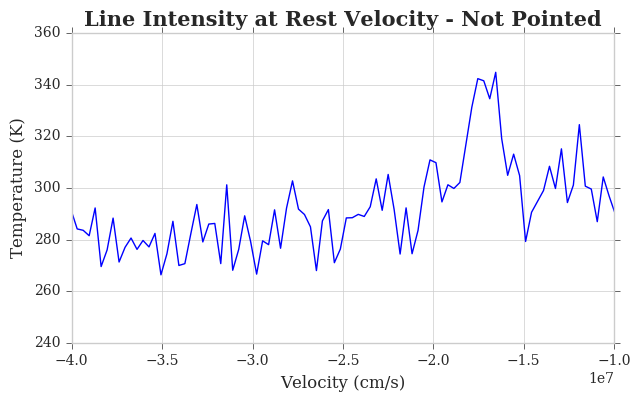

In [12]:
nu = 1420.4
npreal_avgfreqs = np.asarray(npavg_freqs) + 1230 + 190
npdelta_avgnu = npreal_avgfreqs - nu
c = 3 * (10 ** 10) 
npavg_velocity = -(npdelta_avgnu / npreal_avgfreqs) * c
#print (len(avg_velocity)) LOOKS GOOD

fig = plt.figure(figsize = (7, 4))
plt.plot(-np.fft.fftshift(npavg_velocity), np.fft.fftshift(npsmooth_avg), color='b')
plt.xlim(-0.4e8,-0.1e8)
plt.ylim(240, 360)
plt.xlabel('Velocity (cm/s)', fontsize=12)
plt.ylabel('Temperature (K)',  fontsize=12)
plt.title('Line Intensity at Rest Velocity - Not Pointed', fontweight='bold',  fontsize=15)

In [4]:
ra_obs = lst(2458533)
dec_obs = 37.873199
print ('RA = ',ra_obs,'Dec = ',dec_obs)

npdoppler_v = get_projected_velocity(ra_obs, dec_obs, 2458533) * 100
print ('Doppler Velocity =', npdoppler_v / 1e5, ' km/s')

RA =  3.593688063405443 Dec =  37.873199
Doppler Velocity = [-19.70682297]  km/s


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


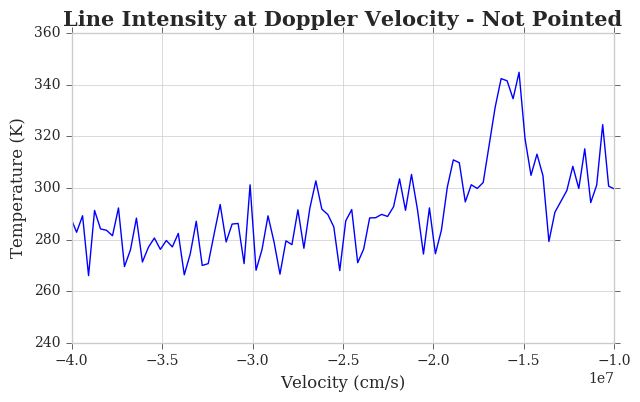

In [14]:
fig = plt.figure(figsize = (7, 4))
plt.plot(-np.fft.fftshift(npavg_velocity - doppler_v), np.fft.fftshift(npsmooth_avg),color='b')
plt.xlim(-0.4e8,-0.1e8)
plt.ylim(240, 360)
plt.legend()
plt.xlabel('Velocity (cm/s)', fontsize=12)
plt.ylabel('Temperature (K)', fontsize=12)
plt.title('Line Intensity at Doppler Velocity - Not Pointed', fontweight='bold', fontsize=15)

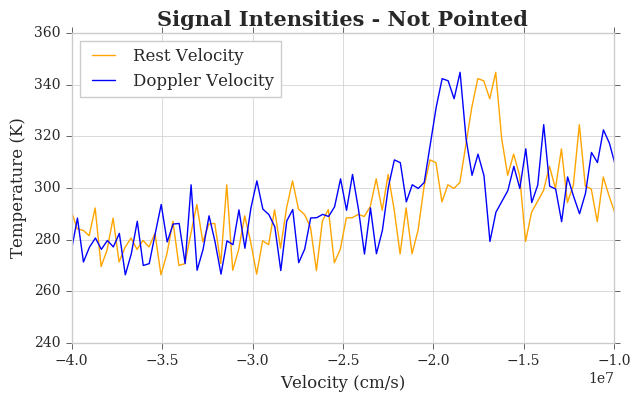

In [17]:
fig = plt.figure(figsize = (7, 4))
plt.plot(-np.fft.fftshift(npavg_velocity), np.fft.fftshift(npsmooth_avg), label = 'Rest Velocity', color='orange')
plt.plot(-np.fft.fftshift(npavg_velocity - npdoppler_v), np.fft.fftshift(npsmooth_avg), label = 'Doppler Velocity', color='b')
plt.xlim(-0.4e8,-0.1e8)
plt.ylim(240, 360)
plt.legend(loc='upper left')
plt.xlabel('Velocity (cm/s)', fontsize=12)
plt.ylabel('Temperature (K)', fontsize=12)
plt.title('Signal Intensities - Not Pointed', fontweight='bold', fontsize=15)

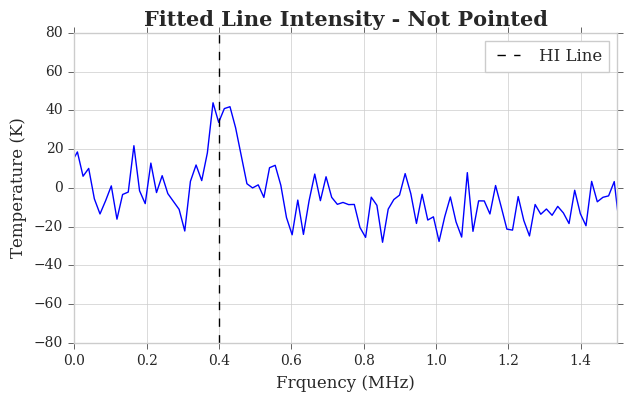

In [18]:
#Polyfit

npx1 = -np.fft.fftshift(npfiltered_avg_freqs)
npy1 = np.fft.fftshift(npfiltered_smoothed_temp)

fitter = modeling.fitting.LevMarLSQFitter()
model = modeling.models.Gaussian1D()   # depending on the data you need to give some initial values
fitted_model = fitter(model, npx1, npy1)

np_y = npy1 - fitted_model(npx1) 

fig = plt.figure(figsize = (7, 4))
plt.plot(npx1, np_y)
plt.xlim(0, 1.5)
plt.ylim(-80,80)
plt.axvline(0.4, linestyle='--', label='HI Line', color='black')
plt.title('Fitted Line Intensity - Not Pointed',  fontweight='bold', fontsize=15)
plt.xlabel('Frquency (MHz)', fontsize=12)
plt.ylabel('Temperature (K)', fontsize=12)
plt.legend()

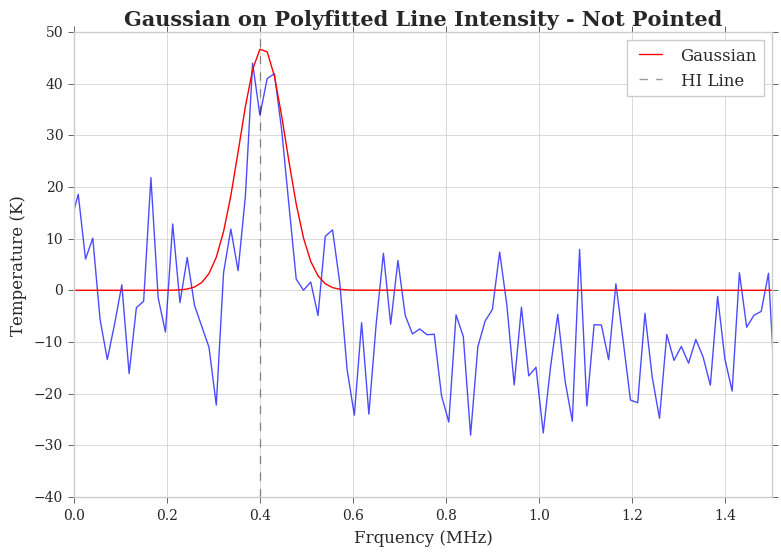

In [19]:
#Gaussfit

npfit_gauss = gaussval(npx1, 47, 0.405, .05)

fig = plt.figure(figsize = (9, 6))
plt.plot(npx1, np_y, alpha=0.7)
plt.plot(npx1, npfit_gauss, label='Gaussian', color='red')
plt.axvline(0.4, linestyle='--',label='HI Line', color='black', alpha=0.4)
plt.title('Gaussian on Polyfitted Line Intensity - Not Pointed', fontweight='bold', fontsize=15)
plt.xlabel('Frquency (MHz)', fontsize=12)
plt.ylabel('Temperature (K)', fontsize=12)
plt.xlim(0,1.5)
plt.ylim(-40,50)
plt.legend()

# Pointed

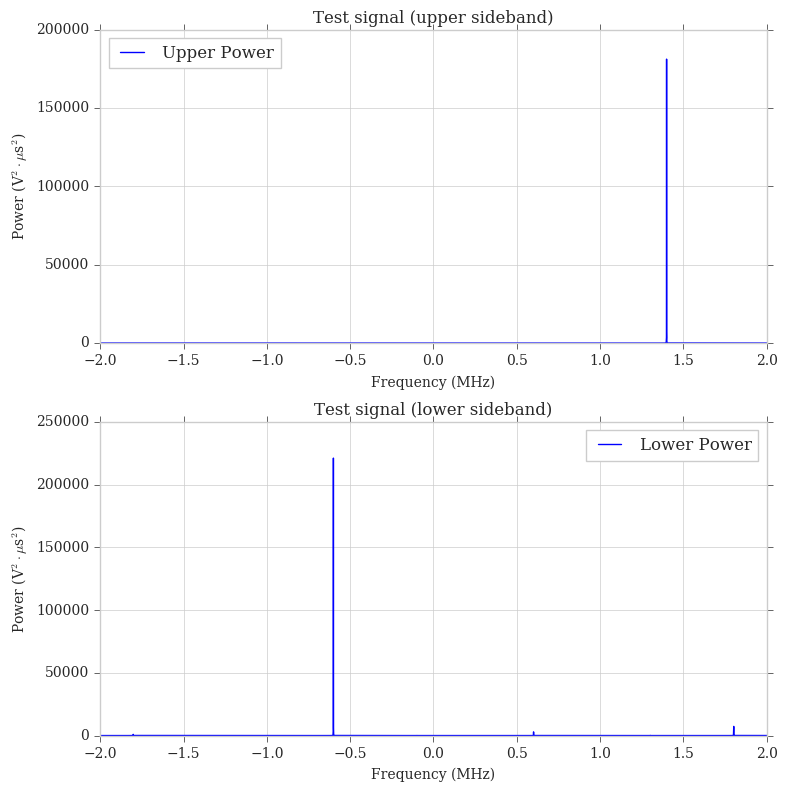

In [20]:
upper_file = '1MHz_above.npy'
lower_file = '1MHz_below.npy'

div = 5.
v_samp = 62.5 / div
v_range = 0.05
nsamples = 16000
nblocks = 99

data, real, imag = load(upper_file, v_range, nblocks)
freqs, power = get_pwr(data, v_samp, nsamples)
avg_upper = np.mean(power, axis = 0)

data, real, imag = load(lower_file, v_range, nblocks)
freqs, power = get_pwr(data, v_samp, nsamples)
avg_lower = np.mean(power, axis = 0)

fig = plt.figure(figsize = (8, 8))

ax1 = plt.subplot(2, 1, 1)
ax1.plot(-np.fft.fftshift(freqs), np.fft.fftshift(avg_upper), label='Upper Power')
ax1.set_xlabel('Frequency (MHz)')
ax1.set_ylabel('Power (V$^2\cdot\mu$s$^2$)')
ax1.set_title('Test signal (upper sideband)')
ax1.set_xlim(-2, 2)

ax2 = plt.subplot(2, 1, 2)
ax2.plot(-np.fft.fftshift(freqs), np.fft.fftshift(avg_lower), label='Lower Power')
ax2.set_xlabel('Frequency (MHz)')
ax2.set_ylabel('Power (V$^2\cdot\mu$s$^2$)')
ax2.set_title('Test signal (lower sideband)')
ax2.set_xlim(-2, 2)

ax1.legend(loc='upper left')
ax2.legend()
fig.tight_layout()

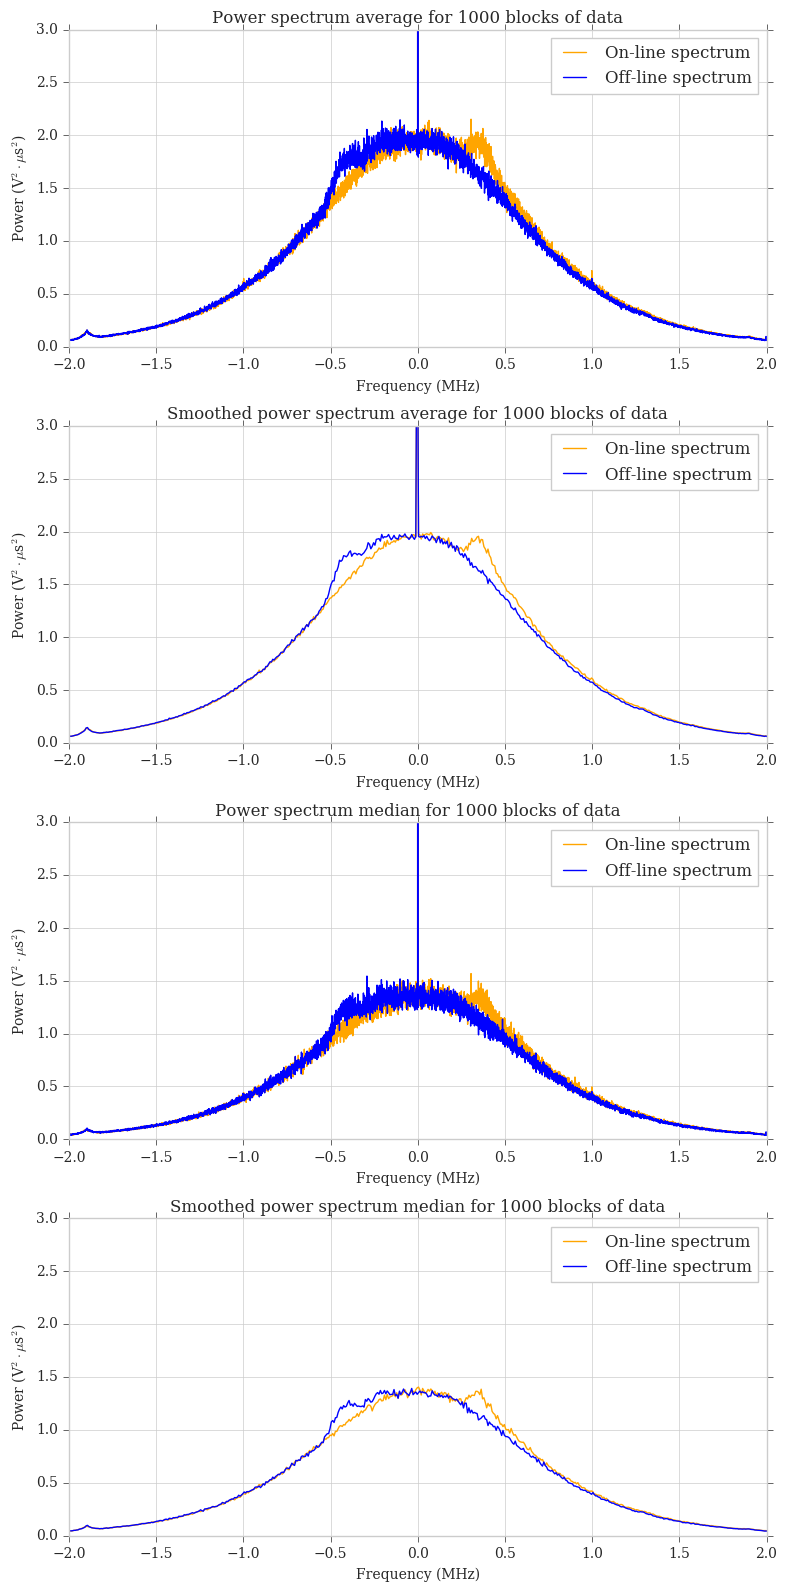

In [21]:
#POINTED

on_file = 'pointed_up_50.npy'
off_file = 'pointed_down_50.npy'

div = 5
v_samp = 62.5 / div
v_range = 0.05
nsamples = 16000
nblocks = 1000

data, real, imag = load(on_file, v_range, nblocks)
freqs_on, power = get_pwr(data, v_samp, nsamples)
avg_on = np.mean(power, axis = 0)
med_on = np.median(power, axis = 0)

data, real, imag = load(off_file, v_range, nblocks)
freqs_off, power = get_pwr(data, v_samp, nsamples)
avg_off = np.mean(power, axis = 0)
med_off = np.median(power, axis = 0)

smooth_div = 10
nsmooth = nsamples // smooth_div
smooth_avg_on, smooth_freqs_on = avg_smooth(avg_on, freqs_on, nsmooth)
smooth_avg_off, smooth_freqs_off = avg_smooth(avg_off, freqs_off, nsmooth)
smooth_med_on, med_freqs_on = med_smooth(med_on, freqs_on, nsmooth)
smooth_med_off, med_freqs_off = med_smooth(med_off, freqs_off, nsmooth)

fig = plt.figure(figsize = (8, 16))

ax1 = plt.subplot(4, 1, 1)
ax1.plot(-np.fft.fftshift(freqs_on), np.fft.fftshift(avg_on), label = 'On-line spectrum', color='orange')
ax1.plot(-np.fft.fftshift(freqs_off), np.fft.fftshift(avg_off), label = 'Off-line spectrum', color='b')
ax1.legend(loc = 'upper right')
ax1.set_xlim(-2, 2)
ax1.set_ylim(0, 3)
ax1.set_xlabel('Frequency (MHz)')
ax1.set_ylabel('Power (V$^2\cdot\mu$s$^2$)')
ax1.set_title('Power spectrum average for 1000 blocks of data')

ax2 = plt.subplot(4, 1, 2)
ax2.plot(-np.fft.fftshift(smooth_freqs_on), np.fft.fftshift(smooth_avg_on), label = 'On-line spectrum', color='orange')
ax2.plot(-np.fft.fftshift(smooth_freqs_off), np.fft.fftshift(smooth_avg_off), label = 'Off-line spectrum', color='b')
ax2.legend(loc = 'upper right')
ax2.set_xlim(-2, 2)
ax2.set_ylim(0, 3)
ax2.set_xlabel('Frequency (MHz)')
ax2.set_ylabel('Power (V$^2\cdot\mu$s$^2$)')
ax2.set_title('Smoothed power spectrum average for 1000 blocks of data')

ax3 = plt.subplot(4, 1, 3)
ax3.plot(-np.fft.fftshift(freqs_on), np.fft.fftshift(med_on), label = 'On-line spectrum', color='orange')
ax3.plot(-np.fft.fftshift(freqs_off), np.fft.fftshift(med_off), label = 'Off-line spectrum', color='b')
ax3.legend(loc = 'upper right')
ax3.set_xlim(-2, 2)
ax3.set_ylim(0, 3)
ax3.set_xlabel('Frequency (MHz)')
ax3.set_ylabel('Power (V$^2\cdot\mu$s$^2$)')
ax3.set_title('Power spectrum median for 1000 blocks of data')

ax4 = plt.subplot(4, 1, 4)
ax4.plot(-np.fft.fftshift(med_freqs_on), np.fft.fftshift(smooth_med_on), label = 'On-line spectrum', color='orange')
ax4.plot(-np.fft.fftshift(med_freqs_off), np.fft.fftshift(smooth_med_off), label = 'Off-line spectrum', color='b')
ax4.legend(loc = 'upper right')
ax4.set_xlim(-2, 2)
ax4.set_ylim(0, 3)
ax4.set_xlabel('Frequency (MHz)')
ax4.set_ylabel('Power (V$^2\cdot\mu$s$^2$)')
ax4.set_title('Smoothed power spectrum median for 1000 blocks of data')

fig.tight_layout()

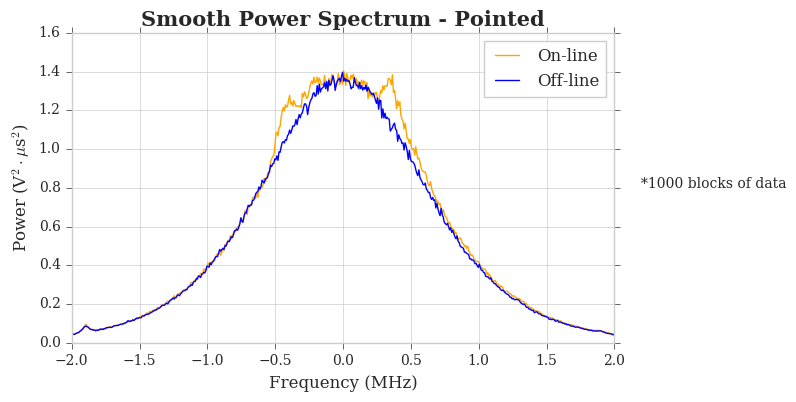

In [22]:
r_on1 , l_on1 = np.split(np.asarray(smooth_med_on),2)
r_off1 , l_off1 = np.split(np.asarray(smooth_med_off),2)

offline_signal = np.concatenate((r_on1,l_off1))
online_signal = np.concatenate((r_off1,l_on1))

fig = plt.figure(figsize = (7, 4))
plt.plot(-np.fft.fftshift(med_freqs_on), np.fft.fftshift(online_signal), label = 'On-line', color='orange')
plt.plot(-np.fft.fftshift(med_freqs_off), np.fft.fftshift(offline_signal), label = 'Off-line', color='b')
plt.xlim(-2,2)
plt.title('Smooth Power Spectrum - Pointed', fontweight='bold', fontsize=15)
plt.xlabel('Frequency (MHz)', fontsize=12)
plt.ylabel('Power (V$^2\cdot\mu$s$^2$)', fontsize=12)
plt.text(2.2, 0.8, '*1000 blocks of data')
plt.legend()

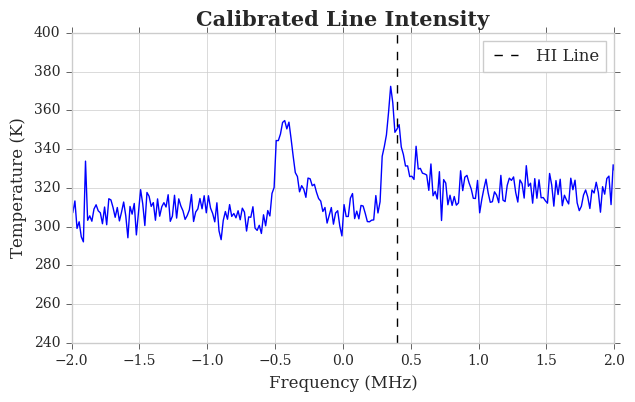

Gain = 304.2228435837575


In [23]:
#POINTED

cal_file = 'cal_data_100mV.npy'
cold_file = 'cold_data_100mV.npy'

v_samp = 12.5
v_range = 0.1
nsamples = 16000
nblocks = 99

cold, real, imag = load(cold_file, v_range, nblocks)
cal, real, imag = load(cal_file, v_range, nblocks)
cold_freqs, cold_pwr = get_pwr(cold, v_samp, nsamples)
cal_freqs, cal_pwr = get_pwr(cal, v_samp, nsamples)
avg_cold = np.mean(cold_pwr, axis = 0)
avg_cal = np.mean(cal_pwr, axis = 0)

avg_line = np.asarray(online_signal) / np.asarray(offline_signal)

gain = 300 * np.sum(avg_cold) / np.sum(avg_cal - avg_cold)
final = gain * avg_line

smooth_div = 20
nsmooth = nsamples // smooth_div
smooth_avg, avg_freqs = avg_smooth(final, cold_freqs, nsmooth)
smooth_med, med_freqs = med_smooth(final, cold_freqs, nsmooth)

fig = plt.figure(figsize = (7, 4))
plt.plot(-np.fft.fftshift(med_freqs), np.fft.fftshift(smooth_med),color='b')
plt.xlim(-2, 2)
plt.ylim(240, 400)
plt.xlabel('Frequency (MHz)', fontsize=12)
plt.ylabel('Temperature (K)', fontsize=12)
plt.axvline(0.4, linestyle='--', color='black', label='HI Line')
plt.title('Calibrated Line Intensity', fontweight='bold', fontsize=15)
plt.legend()
plt.show()
fig.tight_layout()
print('Gain =', gain)

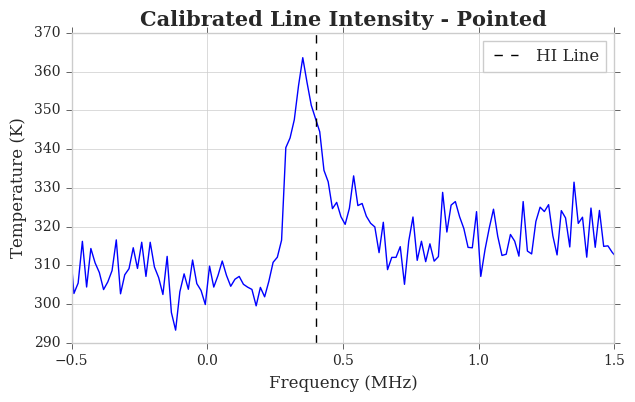

In [196]:
filter = np.ones(len(smooth_med), dtype = bool)
for i in range(len(med_freqs)):
    if med_freqs[i] <= -2 or med_freqs[i]>= 2:
        filter[i] = False
               
smoothed_arr = np.array(smooth_med)
filtered_smoothed_temp = smoothed_arr[filter]   
filtered_med_freqs = np.array(med_freqs)[filter]
max_inrange = np.argmax(np.fft.fftshift(filtered_smoothed_temp))

total = np.fft.fftshift(filtered_smoothed_temp)[80:130] + np.fft.fftshift(filtered_smoothed_temp)[130:180]

mean = total / 2

new_y = np.concatenate((np.fft.fftshift(filtered_smoothed_temp)[0:80], mean, np.fft.fftshift(filtered_smoothed_temp)[180:]))
#print(len(new_y),len(filtered_med_freqs))
fig = plt.figure(figsize = (7, 4))

plt.plot(-np.fft.fftshift(filtered_med_freqs)[:-50], new_y)
plt.xlim(-0.5,1.5)
plt.xlabel('Frequency (MHz)', fontsize=12)
plt.ylabel('Temperature (K)', fontsize=12)
plt.axvline(0.4, linestyle='--', color='black', label='HI Line')
plt.title('Calibrated Line Intensity - Pointed', fontweight='bold', fontsize=15)
plt.legend()

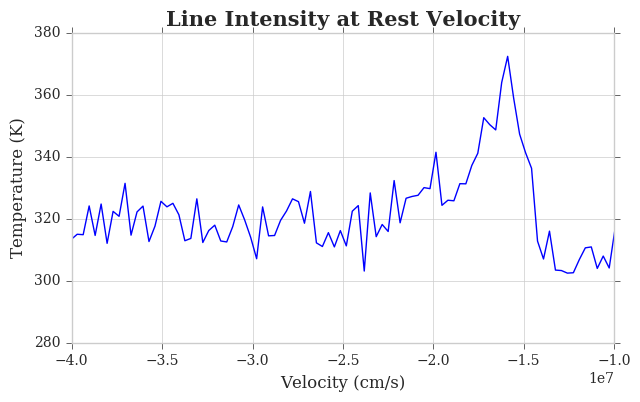

In [202]:
#POINTED

nu = 1420.4
real_avgfreqs = np.asarray(avg_freqs) + 1230 + 190
delta_avgnu = real_avgfreqs - nu
c = 3 * (10 ** 10) 
avg_velocity = -(delta_avgnu / real_avgfreqs) * c
#print (len(avg_velocity)) LOOKS GOOD

real_medfreqs = np.asarray(med_freqs) + 1230 + 190
delta_mednu = real_medfreqs - nu
med_velocity = -(delta_mednu / real_medfreqs) * c
#print(len(med_velocity)) LOOKS GOOD

fig = plt.figure(figsize = (7, 4))
plt.plot(-np.fft.fftshift(med_velocity), np.fft.fftshift(smooth_med), color='b')
plt.xlim(-0.4e8,-0.1e8)
plt.ylim(280, 380)
plt.xlabel('Velocity (cm/s)', fontsize=12)
plt.ylabel('Temperature (K)',  fontsize=12)
plt.title('Line Intensity at Rest Velocity', fontweight='bold',  fontsize=15)

In [186]:
rotation_eqgal = np.array([[-0.054876,-0.873437,-0.48383],[0.494109,-0.444830,0.746982],[-0.867666,-0.198076,0.455984]])
gal_coords = np.array([120,0,0])
r_inv = np.linalg.inv(rotation_eqgal)
ra , dec , r = np.dot(r_inv,gal_coords)
print ('RA = ',ra,'Dec = ',dec, 'r = ', r)

doppler_v = get_projected_velocity(ra, dec, 2458540) * 100
#doppler_v = 1290480.26671753
print ('Doppler Velocity =', doppler_v / 1e5, ' km/s')

RA =  -6.5851572483093275 Dec =  -104.81269661003319 r =  -58.06036339595357
Doppler Velocity = [12.90480291]  km/s


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


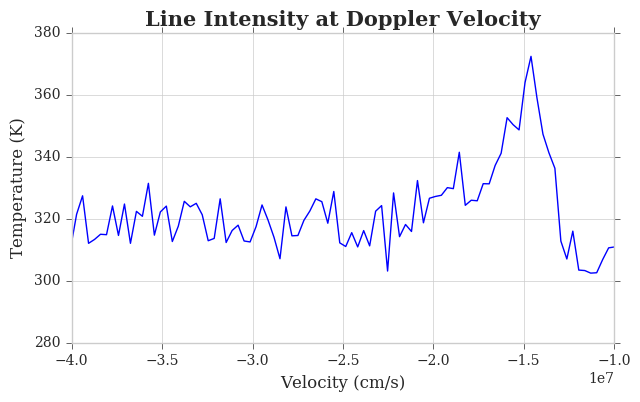

In [27]:
fig = plt.figure(figsize = (7, 4))
plt.plot(-np.fft.fftshift(med_velocity - doppler_v), np.fft.fftshift(smooth_med),color='b')
plt.xlim(-0.4e8,-0.1e8)
plt.ylim(280, 380)
plt.legend()
plt.xlabel('Velocity (cm/s)', fontsize=12)
plt.ylabel('Temperature (K)', fontsize=12)
plt.title('Line Intensity at Doppler Velocity', fontweight='bold', fontsize=15)

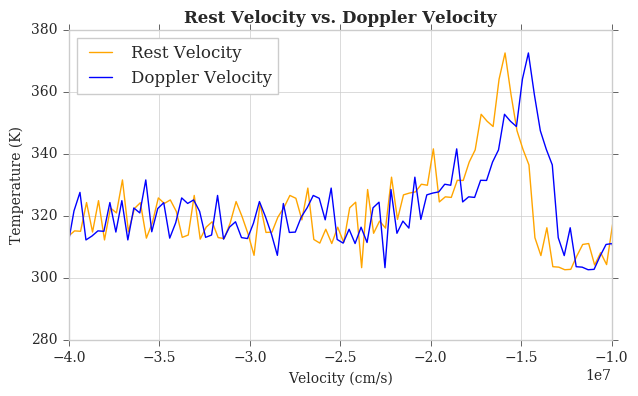

In [28]:
fig = plt.figure(figsize = (7, 4))
plt.plot(-np.fft.fftshift(avg_velocity), np.fft.fftshift(smooth_med), label = 'Rest Velocity', color='orange')
plt.plot(-np.fft.fftshift(avg_velocity - doppler_v), np.fft.fftshift(smooth_med), label = 'Doppler Velocity', color='b')
plt.xlim(-0.4e8,-0.1e8)
plt.ylim(280, 380)
plt.legend(loc='upper left')
plt.xlabel('Velocity (cm/s)')
plt.ylabel('Temperature (K)')
plt.title('Rest Velocity vs. Doppler Velocity', fontweight='bold')

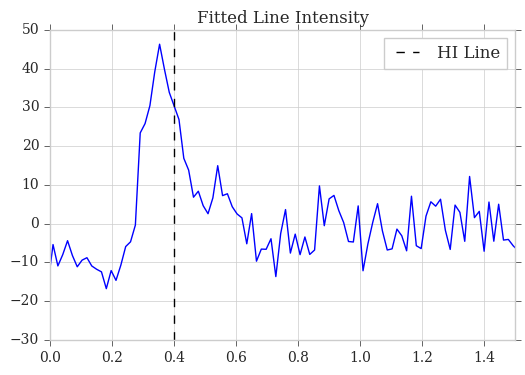

In [193]:
#Polyfit
new_x = -np.fft.fftshift(filtered_med_freqs)[:-50]
new_y = np.concatenate((np.fft.fftshift(filtered_smoothed_temp)[0:80], mean, 
                        np.fft.fftshift(filtered_smoothed_temp)[180:]))

fitter = modeling.fitting.LevMarLSQFitter()
model = modeling.models.Gaussian1D()

adjusted_y = new_y - fitted_model(new_x)

plt.plot(new_x, adjusted_y)
plt.xlim(0, 1.5)
plt.axvline(0.4, linestyle='--', label='HI Line', color='black')
plt.legend()
plt.title('Fitted Line Intensity')

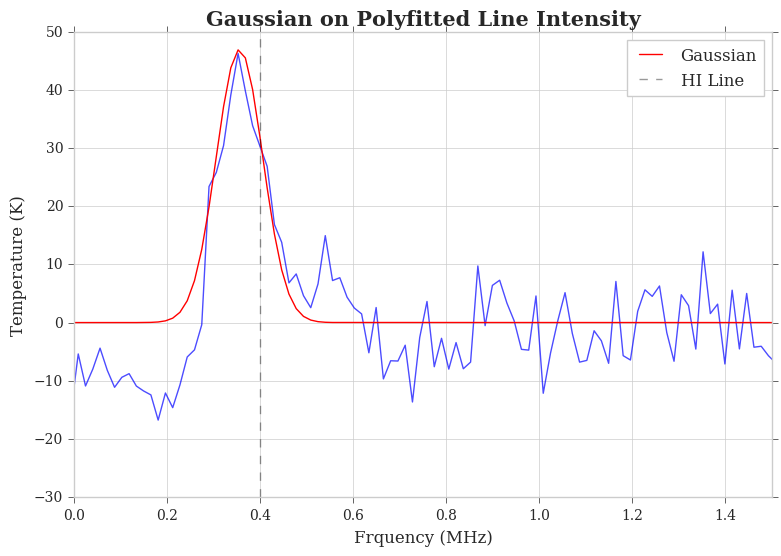

In [30]:
#Gaussfit
fit_gauss = gaussval(x1, 47, 0.355, .05)

fig = plt.figure(figsize = (9, 6))
plt.plot(x1, adjusted_y, alpha=0.7)
plt.plot(x1, fit_gauss, label='Gaussian', color='red')
plt.axvline(0.4, linestyle='--',label='HI Line', color='black', alpha=0.4)
plt.title('Gaussian on Polyfitted Line Intensity', fontweight='bold', fontsize=15)
plt.xlabel('Frquency (MHz)', fontsize=12)
plt.ylabel('Temperature (K)', fontsize=12)
plt.xlim(0,1.5)
plt.legend()

# Waveguides

In [203]:
#C-Band Data
open_3 = np.load('cband_nostop.npy')
closed_3 = np.load('cband_stop.npy')

#X-Band Data
open_75 = np.load('open_75.npy') 
closed_75 = np.load('open_75.npy')
open_8 = np.load('open_85.npy')
closed_8 = np.load('open_85.npy')
open_85 = np.load('xband_nostop.npy')
closed_85 = np.load('xband_stop.npy')

opendata = np.array([open_75, open_8, open_85,])
closeddata = np.array([closed_75, closed_8, closed_85])
print(len(opendata))

3


In [205]:
guide_freqs = np.array([3,7.5,8,8.5]) * 1e9

#Velocities - By Average
dist = []
def lam(data):
    for i in range(len(data)):
        null_dist = data[i+1] - data[i]
        return np.append(dist, null_dist)

"""
velc3_open = c / np.mean(lam(open_3))
velc3_closed = c / np.mean(lam(closed_3))
velx75_open = c / np.mean(lam(open_75))
velx75_closed = c / np.mean(lam(closed_75))
velx8_open = c / np.mean(lam(open_8))
velx8_closed = c / np.mean(lam(closed_8))
velx85_open = c / np.mean(lam(open_85))
velx85_closed = c / np.mean(lam(closed_85))
"""
print(open_3)

#Velocities - By Polyfit
def lampoly(data):
    x = np.arange(1,len(data)+1)
    A , lambda_sl = np.polyfit(x, data, 1)
    return (c / lambda_sl)

vel3_open = (lampoly(open_3)) / 3e10
vel3_closed = (lampoly(closed_3)) / 3e10
vel75_open = (lampoly(open_75)) / 7.5e10
vel75_closed = (lampoly(closed_75)) / 7.5e10
vel8_open = (lampoly(open_8)) / 8e10
vel8_closed = (lampoly(closed_8)) / 8e10
vel85_open = (lampoly(open_85)) / 8.5e10
vel85_closed = (lampoly(closed_85)) / 8.5e10

#Waveguide Width
def waveguide_width(data, freq):
    lambda_g = lampoly(data) / 1e10
    lambdas_fs = c / (freq*8e9)
    guide_width = np.sqrt(1-(lambdas_fs/lambda_g)**2)*(2/lambdas_fs)
    print('Waveguide Width = ',guide_width, 'cm')
    
waveguide_width(closed_8, 8)

[ 5.34 10.34 15.34 20.29 25.29 30.3  35.26 40.33 45.29 50.31]
Waveguide Width =  2.124722204064432 cm


In [210]:
print('C-Band Open Velocity (1e10 cm/s) =',vel3_open,',', 'X-Band Open Velocities (1e10 cm/s) =', vel75_open,'(7.5 Ghz)', vel8_open,'(8.0 GHz)', vel85_open,'(8.5 GHz)')

C-Band Open Velocity (1e10 cm/s) = 2.9940119760480974 , X-Band Open Velocities (1e10 cm/s) = 0.1052631578947369 (7.5 Ghz) 0.0675675675675675 (8.0 GHz) 0.06906872337976284 (8.5 GHz)


In [211]:
print('C-Band Closed Velocity (1e10 cm/s) =',vel3_closed,',', 'X-Band Closed Velocities (1e10 cm/s) =', vel75_closed,'(7.5 Ghz)', vel8_closed,'(8.0 GHz)', vel85_closed,'(8.5 GHz)')

C-Band Closed Velocity (1e10 cm/s) = -0.8426966292134748 , X-Band Closed Velocities (1e10 cm/s) = 0.1052631578947369 (7.5 Ghz) 0.0675675675675675 (8.0 GHz) 0.0751738395038526 (8.5 GHz)


In [149]:
#ERRORS

freqs_arr = list(('7.5', '7.5', '8', '8', '8.5', '8.5'))
style_arr = list(('Open', 'Closed', 'Open', 'Closed', 'Open', 'Closed'))
def errorplt(data, error=0.25):
    for i in range(1, len(data)):
        freq = freqs_arr[i]
        style = style_arr[i]
        x_vals = np.arange(1,len(data[i])+1)
        y_vals = data[i]
        #velocity = lampoly(data) / 1e10
        plt.figure(figsize = (6, 5))
        plt.title('Measurement Errors', fontweight='bold', fontsize=15)
        graph = plt.errorbar(x_vals, y_vals, yerr=error, fmt='o', ecolor='orange')
        plt.ylabel('Null Location (cm)', fontsize=13)
        plt.xlabel('Null Number', fontsize=13)
        plt.legend([graph], (freq,' MHz ','- ',style))

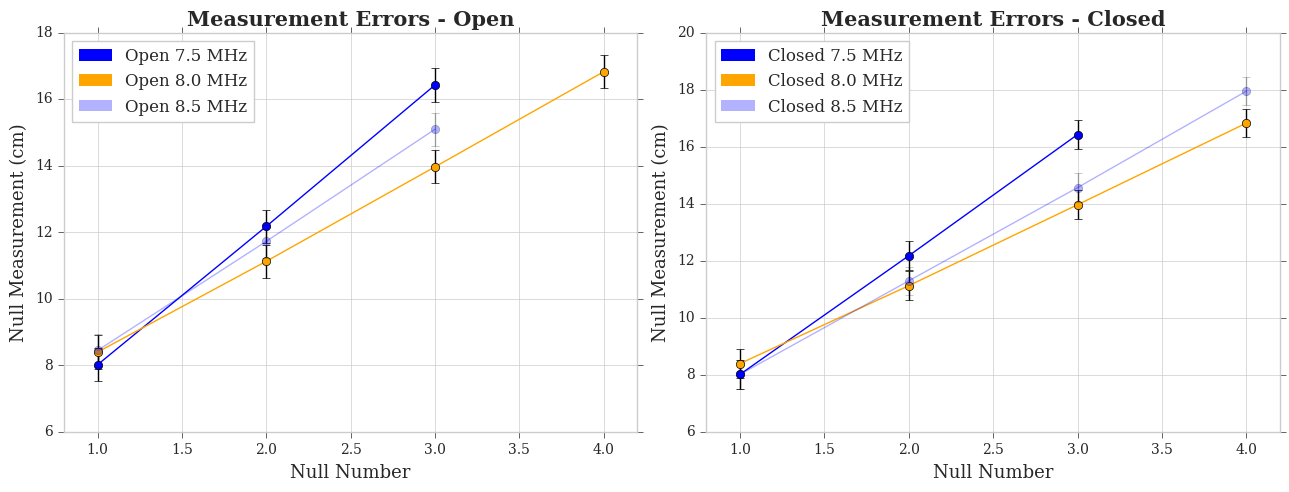

In [187]:
#PLOTTING ERRORS

#OPEN
x_vals75 = np.arange(1,len(opendata[0])+1)
y_vals75 = opendata[0]
x_vals8 = np.arange(1,len(opendata[1])+1)
y_vals8 = opendata[1]
x_vals85 = np.arange(1,len(opendata[2])+1)
y_vals85 = opendata[2]

#CLOSED
x_cvals75 = np.arange(1,len(closeddata[0])+1)
y_cvals75 = closeddata[0]
x_cvals8 = np.arange(1,len(closeddata[1])+1)
y_cvals8 = closeddata[1]
x_cvals85 = np.arange(1,len(closeddata[2])+1)
y_cvals85 = closeddata[2]

fig, axes = plt.subplots(nrows=1,ncols=2, figsize = (13,5))
#PLOTTING OPEN
ax1 = plt.subplot(1, 2, 1)
ax1.set_title('Measurement Errors - Open', fontweight='bold', fontsize=15)
ax1.errorbar(x_vals75, y_vals75, yerr=0.5, fmt='-o', color='b', ecolor='black')
ax1.errorbar(x_vals8, y_vals8, yerr=0.5, fmt='-o', color='orange', ecolor='black')
ax1.errorbar(x_vals85, y_vals85, yerr=0.5, fmt='-o', color='b', alpha=0.3, ecolor='black')
ax1.set_ylabel('Null Measurement (cm)', fontsize=13)
ax1.set_xlabel('Null Number', fontsize=13)
ax1.set_xlim(0.8,4.2)
a = Rectangle((0, 0), 1, 1, fill=True, color='b', linewidth=0)
b = Rectangle((0, 0), 1, 1, fill=True, color='orange', linewidth=0)
c = Rectangle((0, 0), 1, 1, fill=True, color='b', alpha=0.3, linewidth=0)
ax1.legend([a, b, c], ("Open 7.5 MHz", "Open 8.0 MHz", "Open 8.5 MHz"), loc='upper left')

#PLOTTING CLOSED
ax2 = plt.subplot(1, 2, 2)
ax2.set_title('Measurement Errors - Closed', fontweight='bold', fontsize=15)
ax2.errorbar(x_cvals75, y_cvals75, yerr=0.5, fmt='-o', color='b', ecolor='black')
ax2.errorbar(x_cvals8, y_cvals8, yerr=0.5, fmt='-o', color='orange', ecolor='black')
ax2.errorbar(x_cvals85, y_cvals85, yerr=0.5, fmt='-o', color='b', alpha=0.3, ecolor='black')
ax2.set_ylabel('Null Measurement (cm)', fontsize=13)
ax2.set_xlabel('Null Number', fontsize=13)
ax2.set_xlim(0.8,4.2)
d = Rectangle((0, 0), 1, 1, fill=True, color='b', linewidth=0)
e = Rectangle((0, 0), 1, 1, fill=True, color='orange', linewidth=0)
f = Rectangle((0, 0), 1, 1, fill=True, color='b', alpha=0.3, linewidth=0)
ax2.legend([d, e, f], ("Closed 7.5 MHz", "Closed 8.0 MHz", "Closed 8.5 MHz"), loc='upper left')

fig.tight_layout()

plt.savefig('errors.pdf', dpi = 1200,  transparent = True)

# Graphs for Report

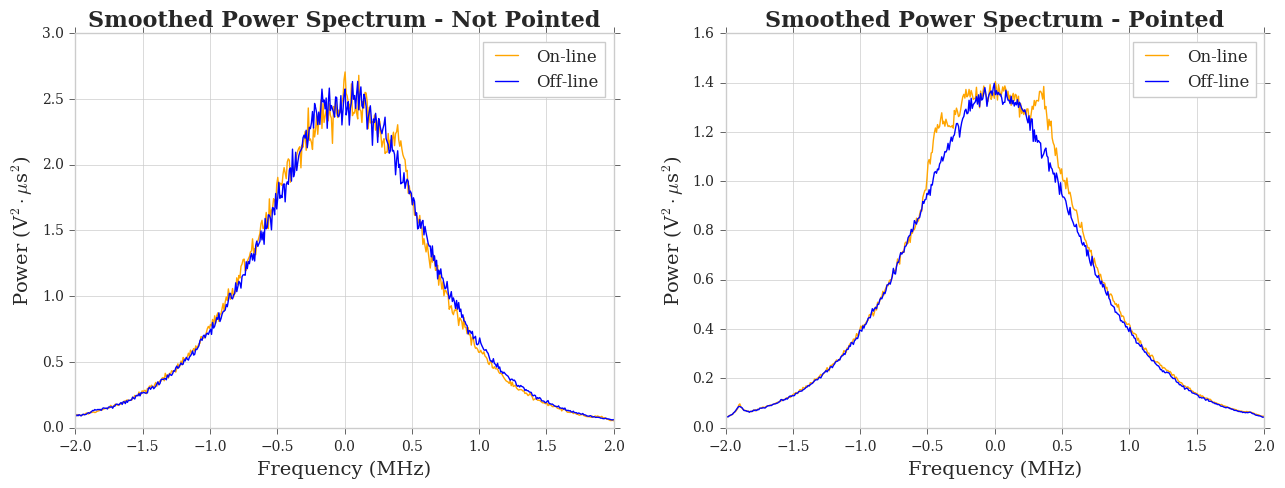

In [559]:
#ON/OFF COMPARED FOR POINTED AND NOT

fig, axes = plt.subplots(nrows=1,ncols=2, figsize = (13,5))

ax1 = plt.subplot(1, 2, 1)
ax1.plot(-np.fft.fftshift(smooth_freqscoldon), np.fft.fftshift(nponline_signal), label = 'On-line', color='orange')
ax1.plot(-np.fft.fftshift(smooth_freqscoldoff), np.fft.fftshift(edited_off), label = 'Off-line', color='blue')
ax1.set_xlim(-2,2)
ax1.set_title('Smoothed Power Spectrum - Not Pointed', fontweight='bold', fontsize=16)
ax1.set_xlabel('Frequency (MHz)', fontsize=14)
ax1.set_ylabel('Power (V$^2\cdot\mu$s$^2$)', fontsize=14)
ax1.legend()

ax2 = plt.subplot(1, 2, 2)
ax2.plot(-np.fft.fftshift(med_freqs_on), np.fft.fftshift(online_signal), label = 'On-line', color='orange')
ax2.plot(-np.fft.fftshift(med_freqs_off), np.fft.fftshift(offline_signal), label = 'Off-line', color='blue')
ax2.set_xlim(-2,2)
ax2.set_title('Smoothed Power Spectrum - Pointed', fontweight='bold', fontsize=16)
ax2.set_xlabel('Frequency (MHz)', fontsize=14)
ax2.set_ylabel('Power (V$^2\cdot\mu$s$^2$)', fontsize=14)
ax2.legend()        

fig.tight_layout()

plt.savefig('on_off_compared.pdf', dpi = 1200,  transparent = True)

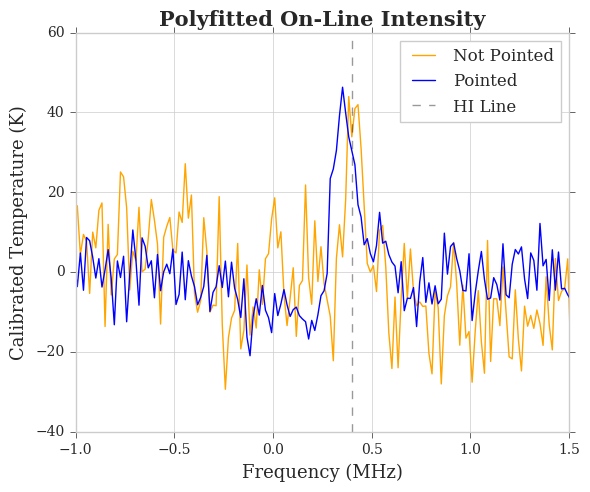

In [549]:
#CALIBRATED LINE INTENSITY COMPARED

fig = plt.figure(figsize = (6, 5))
plt.plot(npx1, np_y,color='orange', label='Not Pointed')
plt.plot(x1, adjusted_y, color='blue', label='Pointed')
plt.xlabel('Frequency (MHz)', fontsize=13)
plt.ylabel('Calibrated Temperature (K)', fontsize=13)
plt.title('Polyfitted On-Line Intensity', fontweight='bold', fontsize=15)
plt.xlim(-1,1.5)
plt.ylim(-40, 60)
plt.axvline(0.4, linestyle='--',label='HI Line', color='black', alpha=0.4)
plt.legend(loc='upper right')

fig.tight_layout()

plt.savefig('line_intensity_compared.pdf', dpi = 1200,  transparent = True)

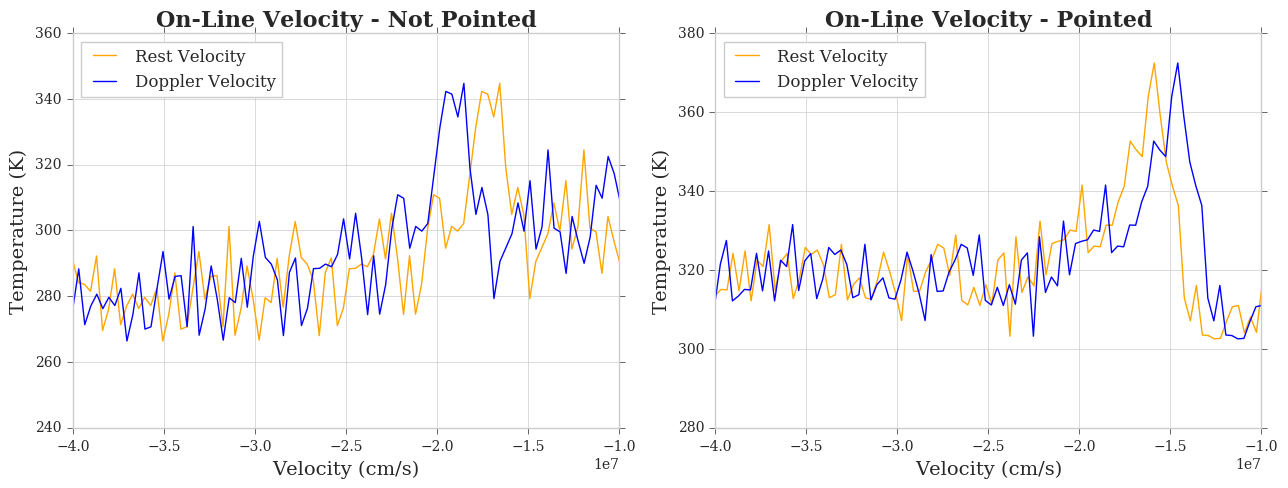

In [35]:
#REST/DOPPLER VELOCITES COMPARED

fig, axes = plt.subplots(nrows=1,ncols=2, figsize = (13,5))

ax1 = plt.subplot(1, 2, 1)
ax1.plot(-np.fft.fftshift(npavg_velocity), np.fft.fftshift(npsmooth_avg), label = 'Rest Velocity', color='orange')
ax1.plot(-np.fft.fftshift(npavg_velocity - npdoppler_v), np.fft.fftshift(npsmooth_avg), label = 'Doppler Velocity', color='blue')
ax1.set_xlim(-0.4e8,-0.1e8)
ax1.set_ylim(240, 360)
ax1.set_title('On-Line Velocity - Not Pointed', fontweight='bold', fontsize=16)
ax1.set_xlabel('Velocity (cm/s)', fontsize=14)
ax1.set_ylabel('Temperature (K)', fontsize=14)
ax1.legend(loc='upper left')

ax2 = plt.subplot(1, 2, 2)
ax2.plot(-np.fft.fftshift(avg_velocity), np.fft.fftshift(smooth_med), label = 'Rest Velocity', color='orange')
ax2.plot(-np.fft.fftshift(avg_velocity - doppler_v), np.fft.fftshift(smooth_med), label = 'Doppler Velocity', color='blue')
ax2.set_xlim(-0.4e8,-0.1e8)
ax2.set_ylim(280, 380)
ax2.set_title('On-Line Velocity - Pointed', fontweight='bold', fontsize=16)
ax2.set_xlabel('Velocity (cm/s)', fontsize=14)
ax2.set_ylabel('Temperature (K)', fontsize=14)
ax2.legend(loc='upper left')        

fig.tight_layout()

plt.savefig('rest_doppler_compared.pdf', dpi = 1200,  transparent = True)

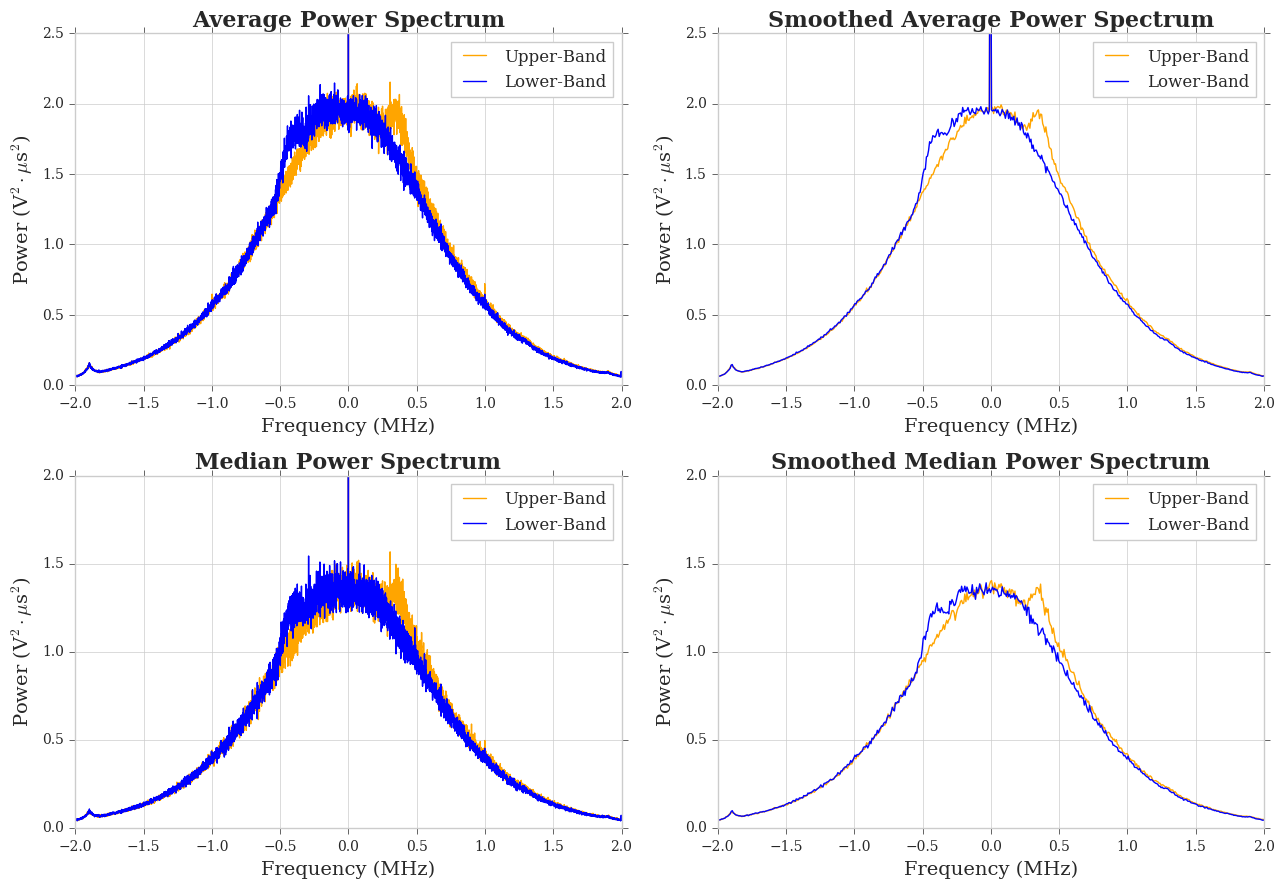

In [37]:
#NOISE REDUCTION

fig = plt.figure(figsize = (13, 9))

ax1 = plt.subplot(2, 2, 1)
ax1.plot(-np.fft.fftshift(freqs_on), np.fft.fftshift(avg_on), label = 'Upper-Band', color='orange')
ax1.plot(-np.fft.fftshift(freqs_off), np.fft.fftshift(avg_off), label = 'Lower-Band', color='b')
ax1.legend(loc = 'upper right')
ax1.set_xlim(-2, 2)
ax1.set_ylim(0, 2.5)
ax1.set_xlabel('Frequency (MHz)', fontsize=14)
ax1.set_ylabel('Power (V$^2\cdot\mu$s$^2$)', fontsize=14)
ax1.set_title('Average Power Spectrum', fontweight='bold', fontsize=16)

ax2 = plt.subplot(2, 2, 2)
ax2.plot(-np.fft.fftshift(smooth_freqs_on), np.fft.fftshift(smooth_avg_on), label = 'Upper-Band', color='orange')
ax2.plot(-np.fft.fftshift(smooth_freqs_off), np.fft.fftshift(smooth_avg_off), label = 'Lower-Band', color='b')
ax2.legend(loc = 'upper right')
ax2.set_xlim(-2, 2)
ax2.set_ylim(0, 2.5)
ax2.set_xlabel('Frequency (MHz)', fontsize=14)
ax2.set_ylabel('Power (V$^2\cdot\mu$s$^2$)', fontsize=14)
ax2.set_title('Smoothed Average Power Spectrum', fontweight='bold', fontsize=16)

ax3 = plt.subplot(2, 2, 3)
ax3.plot(-np.fft.fftshift(freqs_on), np.fft.fftshift(med_on), label = 'Upper-Band', color='orange')
ax3.plot(-np.fft.fftshift(freqs_off), np.fft.fftshift(med_off), label = 'Lower-Band', color='b')
ax3.legend(loc = 'upper right')
ax3.set_xlim(-2, 2)
ax3.set_ylim(0, 2)
ax3.set_xlabel('Frequency (MHz)', fontsize=14)
ax3.set_ylabel('Power (V$^2\cdot\mu$s$^2$)', fontsize=14)
ax3.set_title('Median Power Spectrum', fontweight='bold', fontsize=16)

ax4 = plt.subplot(2, 2, 4)
ax4.plot(-np.fft.fftshift(med_freqs_on), np.fft.fftshift(smooth_med_on), label = 'Upper-Band', color='orange')
ax4.plot(-np.fft.fftshift(med_freqs_off), np.fft.fftshift(smooth_med_off), label = 'Lower-Band', color='b')
ax4.legend(loc = 'upper right')
ax4.set_xlim(-2, 2)
ax4.set_ylim(0, 2)
ax4.set_xlabel('Frequency (MHz)', fontsize=14)
ax4.set_ylabel('Power (V$^2\cdot\mu$s$^2$)', fontsize=14)
ax4.set_title('Smoothed Median Power Spectrum', fontweight='bold', fontsize=16)

fig.tight_layout()

plt.savefig('avg_mean_compared.pdf', dpi = 1200,  transparent = True)